#### *Librairy imports and helper functions*

Python packages used in this project are loaded.

In [71]:
# Base python 3.9.12

import os.path as pth
import matplotlib.pyplot as plt # Matplotlib v3.5.1
import numpy as np # Numpy v1.23.4
import os
import json
import h5py
from typing import Union
import pandas as pd
import pickle as pkl

from src.utils import set_rcParams

set_rcParams() # Loading used matplotlib settings

Json file containing information on clusters are read.

In [72]:
# Read json files containing information about the clusters

with open('clusters_informations_for_hybrid_simulations.json') as json_file:
    clusters_infos =  json.load(json_file)

In [73]:
# Python functions

def generate_reduced_network_node_id_dict(clustered_nodes: list[int]) -> dict:
    """Generates dictionary to identify the remaining nodes from the original network nodes

    Args:
        clustered_nodes (list[int]): list of clustered nodes (in julia indexing)

    Returns:
        dict: dictionary to associate the original node id to the reduced network node ids
    """
    step = 0
    dict_ = {}
    for i in range(71): # There is 71 nodes in the case study network 1
        if (i+1) in clustered_nodes:
            step += 1
        dict_[i] = i-step
    return dict_

def prepocessing(dict_physical_values: dict) -> dict:
    """Some prepocessing on physical values

    Args:
        dict_physical_values (dict): dictionary containing the values

    Returns:
        dict: dictonary of values treated
    """
    # Some prepocessing
    first_dynamic_step_interest = 10*60 # Not take transient parts

    dict_ = {}
    for physical_state_key in dict_physical_values:
        array = np.array(dict_physical_values[physical_state_key])
        if physical_state_key in ['trcs', 'mc']: # We take all for those
            dict_[physical_state_key] = array
        else:
            dict_[physical_state_key] = array[first_dynamic_step_interest:,:]
    return dict_

def compute_mae_with_interval(distribution):
    """Computes the mean with interval confidence of 98%

    Args:
        distribution (numpy): the distribution

    Returns:
        tuple: (mean, +- confidence interval)
    """
    return np.mean(distribution), 1.96*np.std(distribution)/np.sqrt(len(distribution))

def get_hybrid_simulation_performances(scenario_dict_values: dict, model_key: str, clusters_keys:  Union[list[str],str], cluster_key_result: str = None, sources_to_consider=[0,56]) -> dict:
    """Reads the hybrid results and assess the reduced network simulation performances

    Args:
        scenario_dict_values (dict): the dictionary containing the scenario results including full physical and reduced networks
        model_key (str): the model considered [rnn, cnn]
        clusters_keys (Union[list[str],str]): the clusters keys
        cluster_key_result (str, optional): clusters key used for hybrid results name. Defaults to None.

    Raises:
        Exception: if cluster key not well defined

    Returns:
        dict: the dictionary of performances
    """
    incoming_pipes_ids = []
    incoming_pipes_ids_trout_nodes = []
    
    outgoing_pipes_ids = []
    outgoing_pipes_ids_tsout_nodes = []
    
    clustered_nodes = []
    associated_node_ids = dict()
    perfs = dict()
    
    if type(clusters_keys) == list:
        if cluster_key_result == None:
            raise Exception('Cluster key result must be defined for many clusters considered')
        for key in clusters_keys:
            cluster_info = clusters_infos[f'cluster_{key}']
            # print(cluster_info)
            incoming_pipes_ids.extend(cluster_info['incoming_pipes_id'])
            incoming_pipes_ids_trout_nodes.extend(cluster_info['incoming_pipes_remixing_node_id'])
            outgoing_pipes_ids.extend(cluster_info['outgoing_pipe_id'])
            outgoing_pipes_ids_tsout_nodes.extend(cluster_info['outgoing_pipe_remixing_node_id'])
            clustered_nodes.extend(cluster_info['cluster_nodes'])

        associated_node_ids = generate_reduced_network_node_id_dict(clustered_nodes)
        key = cluster_key_result # key to identify dict of results
        
    else:
        key = clusters_keys
        cluster_info = clusters_infos[f'cluster_{key}']
        # print(cluster_info)
        incoming_pipes_ids.extend(cluster_info['incoming_pipes_id'])
        incoming_pipes_ids_trout_nodes.extend(cluster_info['incoming_pipes_remixing_node_id'])
        outgoing_pipes_ids.extend(cluster_info['outgoing_pipe_id'])
        outgoing_pipes_ids_tsout_nodes.extend(cluster_info['outgoing_pipe_remixing_node_id'])
        clustered_nodes.extend(cluster_info['cluster_nodes'])
        associated_node_ids = generate_reduced_network_node_id_dict(cluster_info['cluster_nodes'])

    perfs['key'] = key
    perfs['type'] = cluster_info['cluster_type']
    perfs['clustered_nodes_number'] = len(clustered_nodes)
    perfs['clustered_nodes_percentage'] = 100*(len(clustered_nodes) / 71)
    perfs['clustered_pipes_percentage'] = 100*((len(clustered_nodes)+len(outgoing_pipes_ids)) / 71) # Tree-like assumption => number of nodes == number edges
    
    loads_mare_f = []
    
    for i, el in enumerate(incoming_pipes_ids):
        el_i = incoming_pipes_ids_trout_nodes[i]
        pipe_index = int(el)-1 # Ingoing pipe index in the original network (needed for effective comparison) !! -1 as julia are indexed from 1
        node_index = int(el_i)-1 # Adjacent nodes to the cluster (in the return direction) !! -1 as julia are indexed from 1

        mw = np.abs(np.mean(scenario_dict_values['full_physic']['mw'][:,pipe_index]))
        # print(f'Original incoming pipe (scenario) {el} traversed by mass flow rates with nominal value of {mw:.2f} Kg/s')

        tr_node_mix = scenario_dict_values['full_physic']['tr'][:,node_index]
        ts_node_mix = scenario_dict_values['full_physic']['ts'][:,node_index]
            
        tr_node_mix_reduced = scenario_dict_values[model_key][key]['tr'][:,associated_node_ids[node_index]]
        ts_node_mix_reduced = scenario_dict_values[model_key][key]['ts'][:,associated_node_ids[node_index]]
        
        pw_adj_node = mw*4200*(ts_node_mix-tr_node_mix)
        pw_adj_node_reduced = mw*4200*(ts_node_mix_reduced-tr_node_mix_reduced)
        
        loads_mare_f.extend(100*(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        
    for i, el in enumerate(outgoing_pipes_ids):
        el_i = outgoing_pipes_ids_tsout_nodes[i]
        pipe_index = int(el)-1
        node_index = int(el_i)-1
        
        mw = np.abs(np.mean(scenario_dict_values['full_physic']['mw'][:,pipe_index]))

        tr_node_mix = scenario_dict_values['full_physic']['tr'][:,node_index]
        ts_node_mix = scenario_dict_values['full_physic']['ts'][:,node_index]
        tr_node_mix_reduced = scenario_dict_values[model_key][key]['tr'][:,associated_node_ids[node_index]]
        ts_node_mix_reduced = scenario_dict_values[model_key][key]['ts'][:,associated_node_ids[node_index]]
        
        pw_adj_node = mw*4200*(ts_node_mix-tr_node_mix)
        pw_adj_node_reduced = mw*4200*(ts_node_mix_reduced-tr_node_mix_reduced)
        
        loads_mare_f.extend(100*(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        

    mare_f, conf_f = compute_mae_with_interval(loads_mare_f)
    
    perfs['Thermal loads (MARE)'] = mare_f
    perfs['Thermal loads (MARE-Conf_interval)'] = conf_f
    perfs['Thermal loads (errors)'] = loads_mare_f
        
    tr_node_source_f = scenario_dict_values['full_physic']['tr'][:,sources_to_consider].reshape(1,-1)
    ts_node_source_f = scenario_dict_values['full_physic']['ts'][:,sources_to_consider].reshape(1,-1)
    
    associated_sources_nodes_ids = [associated_node_ids[i] for i in sources_to_consider]
    tr_node_source_reduced_f = scenario_dict_values[model_key][key]['tr'][:,associated_sources_nodes_ids].reshape(1,-1)
    ts_node_source_reduced_f = scenario_dict_values[model_key][key]['ts'][:,associated_sources_nodes_ids].reshape(1,-1)

    mw_source_node_f = scenario_dict_values['full_physic']['mw'][:,sources_to_consider].reshape(1,-1)
    
    pw_adj_node_f = mw_source_node_f*4200*(ts_node_source_f-tr_node_source_f)
    pw_adj_node_reduced_f = mw_source_node_f*4200*(ts_node_source_reduced_f-tr_node_source_reduced_f)
    
    mae_r_f, conf_r_f = compute_mae_with_interval(np.abs(tr_node_source_f-tr_node_source_reduced_f))
    # print(f'Source return temperature conservation (scenario) MAE = {mae_r_f:.4f} °C +- {conf_r_f:.4f}') 
    perfs['Source return temp (MAE)'] = mae_r_f
    perfs['Source return temp (MAE-Conf_interval)'] = conf_r_f
    perfs['Source return temp (errors)'] = np.abs(tr_node_source_f-tr_node_source_reduced_f)

    mare_pw_f, conf_pw_f = compute_mae_with_interval(100*np.abs(1 - pw_adj_node_reduced_f/pw_adj_node_f))
    # print(f'Source generation power conservation (scenario) MARE = {mare_pw_f:.4f} % +- {conf_pw_f:.4f}') 
    perfs['Source gen (MARE)'] = mare_pw_f
    perfs['Source gen (MARE-Conf_interval)'] = conf_pw_f
    perfs['Source gen (errors)'] = 100*np.abs(1 - pw_adj_node_reduced_f/pw_adj_node_f)
    
    return perfs


#### **1st scenario**

In [202]:
# Loading values from the save pickle files

import pickle as pkl 

folder_scenario = 'scenario_1_results'
results_dicts = {}

with open(os.path.join(folder_scenario, 'results_full_network.pkl'), 'rb') as f:
    results_dicts['baseline'] = pkl.load(f, encoding='bytes')
    
for model in ['rnn', 'cnn']:
    results_dicts[model] = {}
    for key in  ['a', 'b', 'd', 'e', 'f', 'g', 'i', 'm']:
        file_pkl = os.path.join(folder_scenario, f'results_{model}_{key}.pkl')
        if not os.path.exists(file_pkl):
            file_pkl = os.path.join(folder_scenario, f'results_{model}_{key}_v2.pkl')
            if not os.path.exists(file_pkl):
                print(f'Results for cluster {key} of model {model} not found')
                continue
        with open(file_pkl, "rb") as f:
            results_dict = pkl.load(f ,encoding='bytes')
        results_dicts[model][key] = results_dict

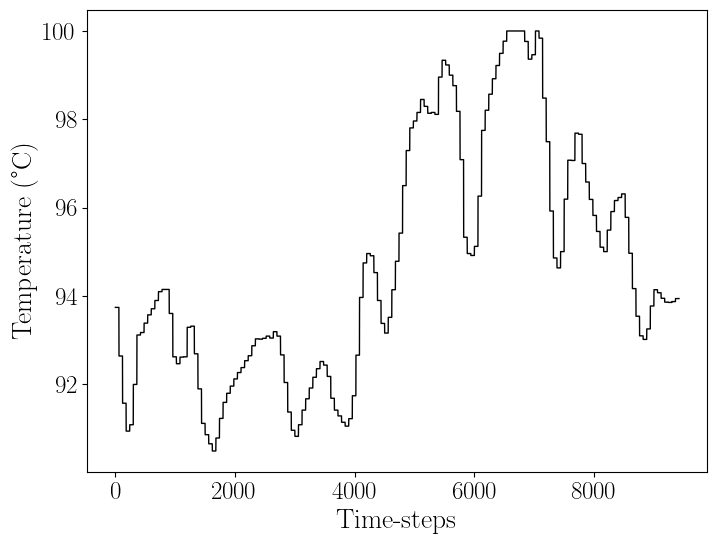

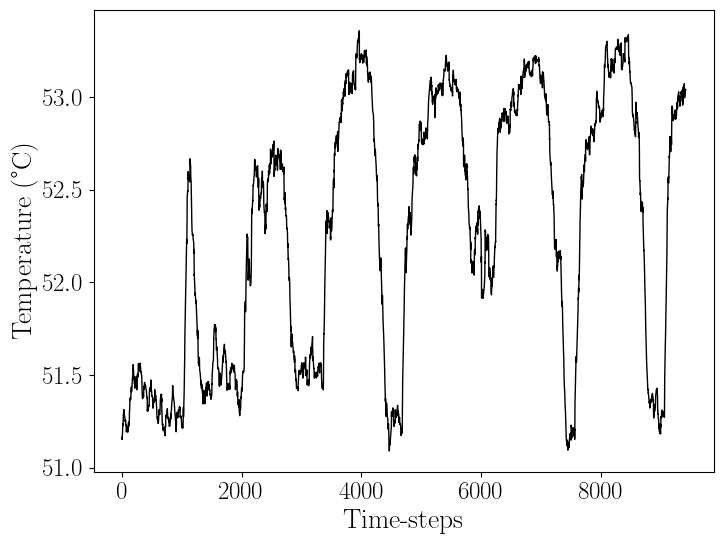

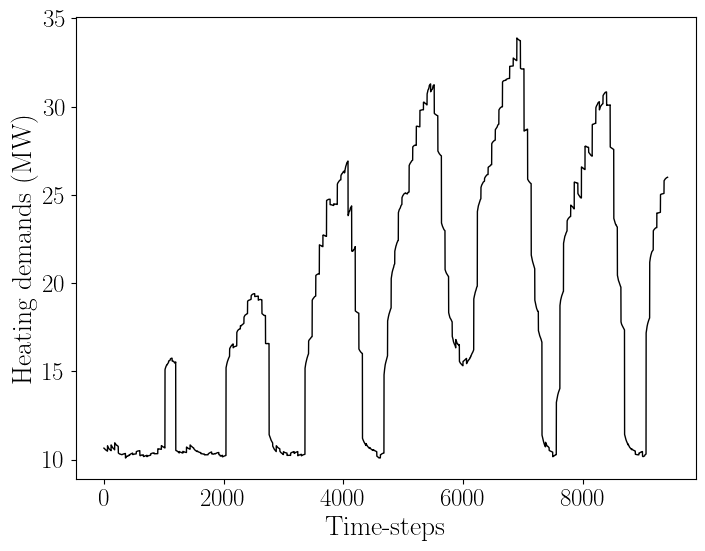

In [203]:
# Some plots from the physical simulation

# Generation source supply temperatures
physical_simulation = results_dicts['baseline']
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(physical_simulation['ts'][:,0], c='black') # Supply temperatures at the source node v_1
ax.set_xlabel('Time-steps')
ax.set_ylabel('Temperature (°C)')
plt.savefig(os.path.join('.', 'ARTICLE_images', 'used_tss_scenario_1.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

# Generation source return temperatures
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(physical_simulation['tr'][:,0], c='black') # Supply temperatures at the source node v_1
ax.set_xlabel('Time-steps')
ax.set_ylabel('Temperature (°C)')
plt.savefig(os.path.join('.', 'ARTICLE_images', 'tr_source_scenario_1.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

# Generation source return temperatures
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(physical_simulation['load'].sum(axis=1) * 1e-6, c='black') # Supply temperatures at the source node v_1
ax.set_xlabel('Time-steps')
ax.set_ylabel('Heating demands (MW)')
plt.savefig(os.path.join('.', 'ARTICLE_images', 'heating_demands_scenario_1.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

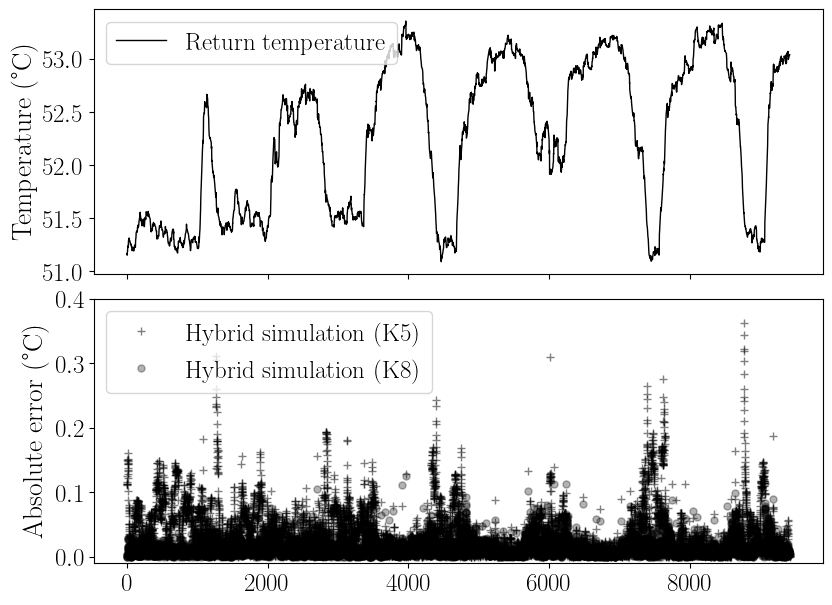

In [204]:
fig, axes = plt.subplots(figsize=(8,6), nrows=2, height_ratios=[1,1], sharex=True)
fig.tight_layout(pad=0.1)
axes[0].plot(physical_simulation['tr'][:,0], c='black', label='Return temperature')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend(loc='upper left', prop={'size': 18}) # place legend outside
# axes[1].plot(results_dicts['rnn']['a']['Source return temp (errors)'].T, c='black', linewidth=1.2, label='Hybrid simulation (K1)', zorder=3)
axes[1].plot(results_dicts['rnn']['f']['Source return temp (errors)'].T, '+', c='black', linewidth=0.8, alpha=0.5, label='Hybrid simulation (K5)', zorder=2)
axes[1].plot(results_dicts['rnn']['g']['Source return temp (errors)'].T, 'o', markersize=5.1, c='black', alpha=0.3, label='Hybrid simulation (K8)', zorder=1)
axes[1].set_ylabel('Absolute error (°C)')
axes[1].set_ylim([-0.01,0.4])
axes[1].legend(loc='upper left', prop={'size': 18}) # place legend outside
plt.savefig(os.path.join('.', 'ARTICLE_images', 'tr_source_hybrid_scenario_1.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

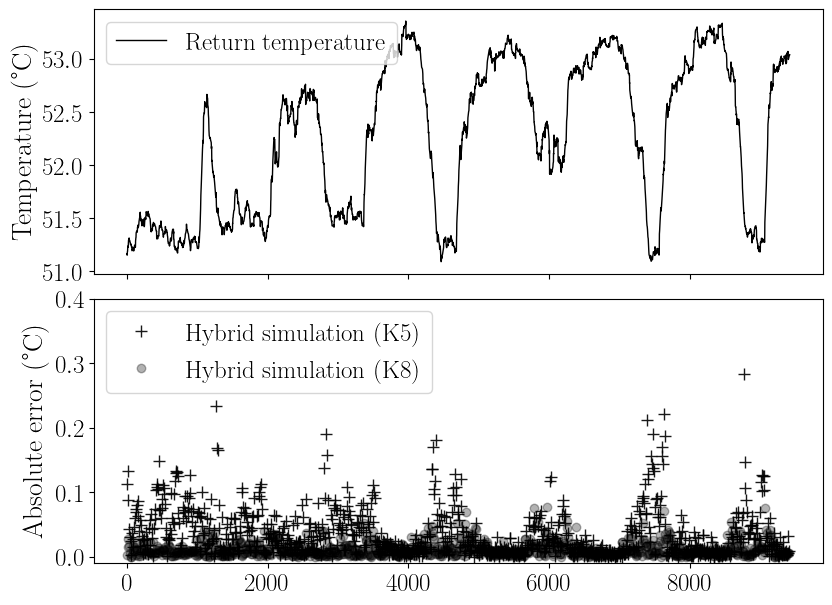

In [205]:

fig, axes = plt.subplots(figsize=(8, 6), nrows=2, height_ratios=[1, 1], sharex=True)
fig.tight_layout(pad=0.1)

# Top plot (unchanged)
axes[0].plot(physical_simulation['tr'][:, 0], c='black', label='Return temperature')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend(loc='upper left', prop={'size': 18})  # place legend outside

# Second plot (show only even x-axis points)
x_axis = results_dicts['rnn']['a']['Source return temp (errors)'].T[:, ::10]  # select even indices

# axes[1].plot(np.arange(0, len(x_axis), 10), results_dicts['rnn']['a']['Source return temp (errors)'].T[::10], c='black', linewidth=1.2, label='Hybrid simulation (K1)', zorder=3)
axes[1].plot(np.arange(0, len(x_axis), 10), results_dicts['rnn']['f']['Source return temp (errors)'].T[::10], '+', markersize=8.4, c='black', linewidth=0.8, alpha=0.9, label='Hybrid simulation (K5)', zorder=1)
axes[1].plot(np.arange(0, len(x_axis), 10), results_dicts['rnn']['g']['Source return temp (errors)'].T[::10], 'o', markersize=6.1, c='black', alpha=0.3, label='Hybrid simulation (K8)', zorder=2)
axes[1].set_ylabel('Absolute error (°C)')
axes[1].set_ylim([-0.01, 0.4])
axes[1].legend(loc='upper left', prop={'size': 18})  # place legend outside

plt.savefig(os.path.join('.', 'ARTICLE_images', 'tr_source_hybrid_scenario_1.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

In [206]:
# Show mean errors

for model_key in results_dicts:
    if model_key == 'baseline':
        continue
    print(f'Model {model_key} -------------------')
    for key in results_dicts[model_key]:
        vals = results_dicts[model_key][key]
        print(f'--> Cluster {key}')
        print(f"----> Loads mape = {vals['Thermal loads (MARE)']:.4f} +- ({vals['Thermal loads (MARE-Conf_interval)']:.4f}) \%")
        print(f"----> Gen power mape = {vals['Source gen (MARE)']:.4f} +- ({vals['Source gen (MARE-Conf_interval)']:.4f}) \%")

Model rnn -------------------
--> Cluster a
----> Loads mape = 0.0430 +- (0.0010) \%
----> Gen power mape = 0.0123 +- (0.0289) \%
--> Cluster b
----> Loads mape = 0.1185 +- (0.0027) \%
----> Gen power mape = 0.0142 +- (0.0307) \%
--> Cluster d
----> Loads mape = 0.0866 +- (0.0019) \%
----> Gen power mape = 0.0245 +- (0.0526) \%
--> Cluster e
----> Loads mape = 0.0535 +- (0.0012) \%
----> Gen power mape = 0.0348 +- (0.0746) \%
--> Cluster f
----> Loads mape = 0.1153 +- (0.0024) \%
----> Gen power mape = 0.0882 +- (0.1797) \%
--> Cluster g
----> Loads mape = 0.0837 +- (0.0018) \%
----> Gen power mape = 0.0289 +- (0.0561) \%
--> Cluster i
----> Loads mape = 0.2944 +- (0.0057) \%
----> Gen power mape = 0.0331 +- (0.0556) \%
--> Cluster m
----> Loads mape = 0.0934 +- (0.0017) \%
----> Gen power mape = 0.0394 +- (0.0728) \%
Model cnn -------------------
--> Cluster a
----> Loads mape = 0.0445 +- (0.0011) \%
----> Gen power mape = 0.0127 +- (0.0302) \%
--> Cluster b
----> Loads mape = 0.1253 

In [207]:
# Saving dicts results to scenario 1

results_dicts_scenario_1 = results_dicts.copy()

#### **2nd scenario**

In [208]:
# Loading values from the save pickle files

import pickle as pkl 

folder_scenario = 'scenario_2_results'
results_dicts = {}

with open(os.path.join(folder_scenario, 'results_full_network.pkl'), 'rb') as f:
    results_dicts['baseline'] = pkl.load(f, encoding='bytes')
    
for model in ['rnn', 'cnn']:
    results_dicts[model] = {}
    for key in  ['a', 'b', 'd', 'e', 'f', 'g', 'i', 'm']:
        file_pkl = os.path.join(folder_scenario, f'results_{model}_{key}.pkl')
        if not os.path.exists(file_pkl):
            file_pkl = os.path.join(folder_scenario, f'results_{model}_{key}_v2.pkl')
            if not os.path.exists(file_pkl):
                print(f'Results for cluster {key} of model {model} not found')
                continue
        with open(file_pkl, "rb") as f:
            results_dict = pkl.load(f ,encoding='bytes')
        results_dicts[model][key] = results_dict

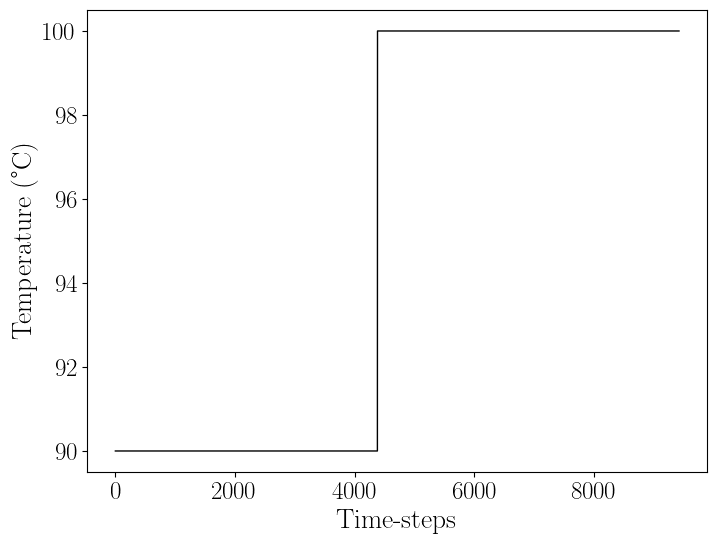

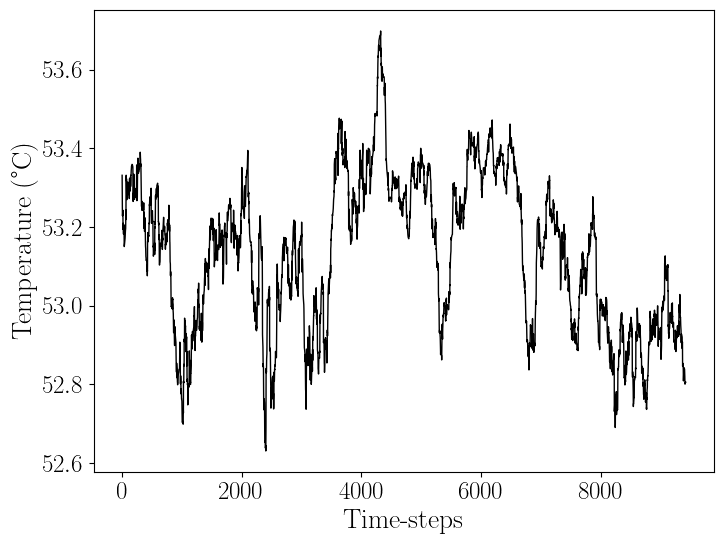

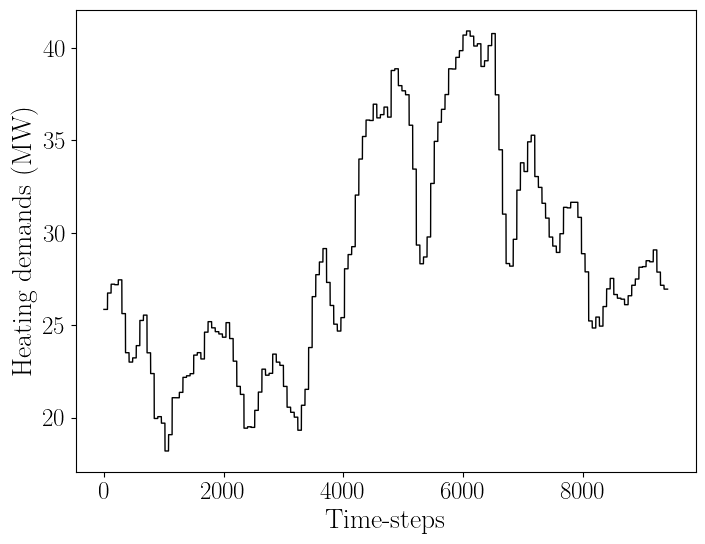

In [209]:
# Some plots from the physical simulation

# Generation source supply temperatures
physical_simulation = results_dicts['baseline']
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(physical_simulation['ts'][:,0], c='black') # Supply temperatures at the source node v_1
ax.set_xlabel('Time-steps')
ax.set_ylabel('Temperature (°C)')
plt.savefig(os.path.join('.', 'ARTICLE_images', 'used_tss_scenario_2.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

# Generation source return temperatures
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(physical_simulation['tr'][:,0], c='black') # Supply temperatures at the source node v_1
ax.set_xlabel('Time-steps')
ax.set_ylabel('Temperature (°C)')
plt.savefig(os.path.join('.', 'ARTICLE_images', 'tr_source_scenario_2.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

# Generation source return temperatures
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(physical_simulation['topology_load'].sum(axis=1) * 1e-6, c='black') # Supply temperatures at the source node v_1
ax.set_xlabel('Time-steps')
ax.set_ylabel('Heating demands (MW)')
plt.savefig(os.path.join('.', 'ARTICLE_images', 'heating_demands_scenario_2.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

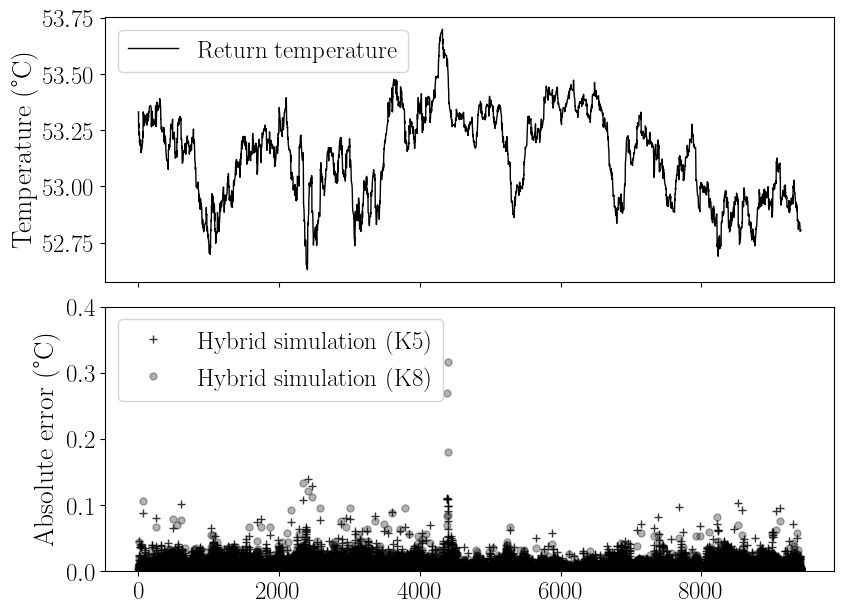

In [188]:
fig, axes = plt.subplots(figsize=(8,6), nrows=2, height_ratios=[1,1], sharex=True)
fig.tight_layout(pad=0.1)
axes[0].plot(physical_simulation['tr'][:,0], c='black', label='Return temperature')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend(loc='upper left', prop={'size': 18}) # place legend outside
axes[1].plot(results_dicts['rnn']['f']['Source return temp (errors)'].T, '+', markersize=5.4, c='black', linewidth=0.8, alpha=0.8, label='Hybrid simulation (K5)', zorder=2)
axes[1].plot(results_dicts['rnn']['g']['Source return temp (errors)'].T, 'o', markersize=5.1, c='black', alpha=0.3, label='Hybrid simulation (K8)', zorder=1)
axes[1].set_ylabel('Absolute error (°C)')
axes[1].set_ylim([0,0.4])
axes[1].legend(loc='upper left', prop={'size': 18}) # place legend outside
plt.savefig(os.path.join('.', 'ARTICLE_images', 'tr_source_hybrid_scenario_2.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

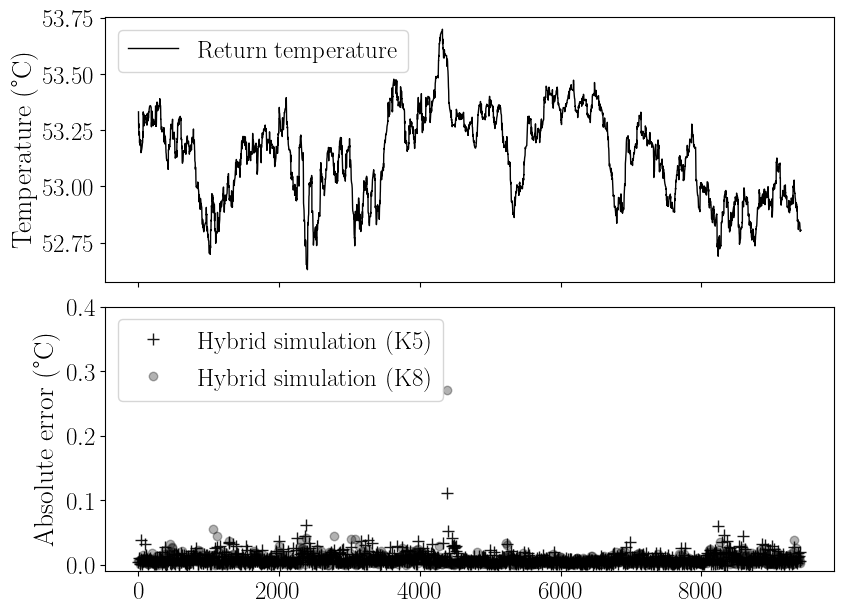

In [210]:
fig, axes = plt.subplots(figsize=(8, 6), nrows=2, height_ratios=[1, 1], sharex=True)
fig.tight_layout(pad=0.1)

# Top plot (unchanged)
axes[0].plot(physical_simulation['tr'][:, 0], c='black', label='Return temperature')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend(loc='upper left', prop={'size': 18})  # place legend outside

# Second plot (show only even x-axis points)
x_axis = results_dicts['rnn']['a']['Source return temp (errors)'].T[:, ::10]  # select even indices

# axes[1].plot(np.arange(0, len(x_axis), 10), results_dicts['rnn']['a']['Source return temp (errors)'].T[::10], c='black', linewidth=1.2, label='Hybrid simulation (K1)', zorder=3)
axes[1].plot(np.arange(0, len(x_axis), 10), results_dicts['rnn']['f']['Source return temp (errors)'].T[::10], '+', markersize=8.4, c='black', linewidth=0.8, alpha=0.9, label='Hybrid simulation (K5)', zorder=1)
axes[1].plot(np.arange(0, len(x_axis), 10), results_dicts['rnn']['g']['Source return temp (errors)'].T[::10], 'o', markersize=6.1, c='black', alpha=0.3, label='Hybrid simulation (K8)', zorder=2)
axes[1].set_ylabel('Absolute error (°C)')
axes[1].set_ylim([-0.01, 0.4])
axes[1].legend(loc='upper left', prop={'size': 18})  # place legend outside

plt.savefig(os.path.join('.', 'ARTICLE_images', 'tr_source_hybrid_scenario_2.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

In [189]:
# Show mean errors

for model_key in results_dicts:
    if model_key == 'baseline':
        continue
    print(f'Model {model_key} -------------------')
    for key in results_dicts[model_key]:
        vals = results_dicts[model_key][key]
        print(f'--> Cluster {key}')
        print(f"----> Loads mape = {vals['Thermal loads (MARE)']:.4f} +- ({vals['Thermal loads (MARE-Conf_interval)']:.4f}) \%")
        print(f"----> Gen power mape = {vals['Source gen (MARE)']:.4f} +- ({vals['Source gen (MARE-Conf_interval)']:.4f}) \%")

Model rnn -------------------
--> Cluster a
----> Loads mape = 0.0070 +- (0.0002) \%
----> Gen power mape = 0.0019 +- (0.0053) \%
--> Cluster b
----> Loads mape = 0.0159 +- (0.0006) \%
----> Gen power mape = 0.0019 +- (0.0067) \%
--> Cluster d
----> Loads mape = 0.0243 +- (0.0007) \%
----> Gen power mape = 0.0066 +- (0.0178) \%
--> Cluster e
----> Loads mape = 0.0164 +- (0.0004) \%
----> Gen power mape = 0.0106 +- (0.0258) \%
--> Cluster f
----> Loads mape = 0.0314 +- (0.0007) \%
----> Gen power mape = 0.0241 +- (0.0507) \%
--> Cluster g
----> Loads mape = 0.0327 +- (0.0018) \%
----> Gen power mape = 0.0206 +- (0.0531) \%
--> Cluster i
----> Loads mape = 0.1606 +- (0.0046) \%
----> Gen power mape = 0.0187 +- (0.0300) \%
--> Cluster m
----> Loads mape = 0.0381 +- (0.0022) \%
----> Gen power mape = 0.0206 +- (0.0452) \%
Model cnn -------------------
--> Cluster a
----> Loads mape = 0.0072 +- (0.0002) \%
----> Gen power mape = 0.0020 +- (0.0055) \%
--> Cluster b
----> Loads mape = 0.0175 

In [190]:
# Saving dicts results to scenario 2

results_dicts_scenario_2 = results_dicts.copy()

#### **3rd scenario**

In [5]:
# Loading values from the save pickle files

import pickle as pkl 

folder_scenario = 'scenario_3_results'
results_dicts = {}

with open(os.path.join(folder_scenario, 'results_full_network.pkl'), 'rb') as f:
    results_dicts['baseline'] = pkl.load(f, encoding='bytes')
    
for model in ['rnn', 'cnn']:
    results_dicts[model] = {}
    for key in  ['a', 'b', 'd', 'e', 'f', 'g', 'i', 'm']:
        file_pkl = os.path.join(folder_scenario, f'results_{model}_{key}.pkl')
        if not os.path.exists(file_pkl):
            file_pkl = os.path.join(folder_scenario, f'results_{model}_{key}_v2.pkl')
            if not os.path.exists(file_pkl):
                print(f'Results for cluster {key} of model {model} not found')
                continue
        with open(file_pkl, "rb") as f:
            results_dict = pkl.load(f ,encoding='bytes')
        results_dicts[model][key] = results_dict

In [ ]:
# Some plots from the physical simulation

# Generation source supply temperatures
physical_simulation = results_dicts['baseline']
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(physical_simulation['ts'][:,0], c='black') # Supply temperatures at the source node v_1
ax.set_xlabel('Time-steps')
ax.set_ylabel('Temperature (°C)')
plt.savefig(os.path.join('.', 'ARTICLE_images', 'used_tss_scenario_3.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

# Generation source return temperatures
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(physical_simulation['tr'][:,0], c='black') # Supply temperatures at the source node v_1
ax.set_xlabel('Time-steps')
ax.set_ylabel('Temperature (°C)')
plt.savefig(os.path.join('.', 'ARTICLE_images', 'tr_source_scenario_3.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

# Generation source return temperatures
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(physical_simulation['load'].sum(axis=1) * 1e-6, c='black') # Supply temperatures at the source node v_1
ax.set_xlabel('Time-steps')
ax.set_ylabel('Heating demands (MW)')
plt.savefig(os.path.join('.', 'ARTICLE_images', 'heating_demands_scenario_3.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

In [7]:
# Show mean errors

for model_key in results_dicts:
    if model_key == 'baseline':
        continue
    print(f'Model {model_key} -------------------')
    for key in results_dicts[model_key]:
        vals = results_dicts[model_key][key]
        print(f'--> Cluster {key}')
        print(f"----> Loads mape = {vals['Thermal loads (MARE)']:.4f} +- ({vals['Thermal loads (MARE-Conf_interval)']:.4f}) \%")
        print(f"----> Gen power mape = {vals['Source gen (MARE)']:.4f} +- ({vals['Source gen (MARE-Conf_interval)']:.4f}) \%")

Model rnn -------------------
--> Cluster a
----> Loads mape = 0.0311 +- (0.0009) \%
----> Gen power mape = 0.0089 +- (0.0240) \%
--> Cluster b
----> Loads mape = 0.0679 +- (0.0022) \%
----> Gen power mape = 0.0075 +- (0.0232) \%
--> Cluster d
----> Loads mape = 0.0645 +- (0.0018) \%
----> Gen power mape = 0.0180 +- (0.0481) \%
--> Cluster e
----> Loads mape = 0.0479 +- (0.0014) \%
----> Gen power mape = 0.0309 +- (0.0852) \%
--> Cluster f
----> Loads mape = 0.1242 +- (0.0030) \%
----> Gen power mape = 0.0947 +- (0.2224) \%
--> Cluster g
----> Loads mape = 0.1037 +- (0.0046) \%
----> Gen power mape = 0.0301 +- (0.0578) \%
--> Cluster i
----> Loads mape = 0.5189 +- (0.0157) \%
----> Gen power mape = 0.0395 +- (0.0790) \%
--> Cluster m
----> Loads mape = 0.0861 +- (0.0034) \%
----> Gen power mape = 0.0423 +- (0.0863) \%
Model cnn -------------------
--> Cluster a
----> Loads mape = 0.0329 +- (0.0009) \%
----> Gen power mape = 0.0093 +- (0.0257) \%
--> Cluster b
----> Loads mape = 0.0615 

#### **Plots**

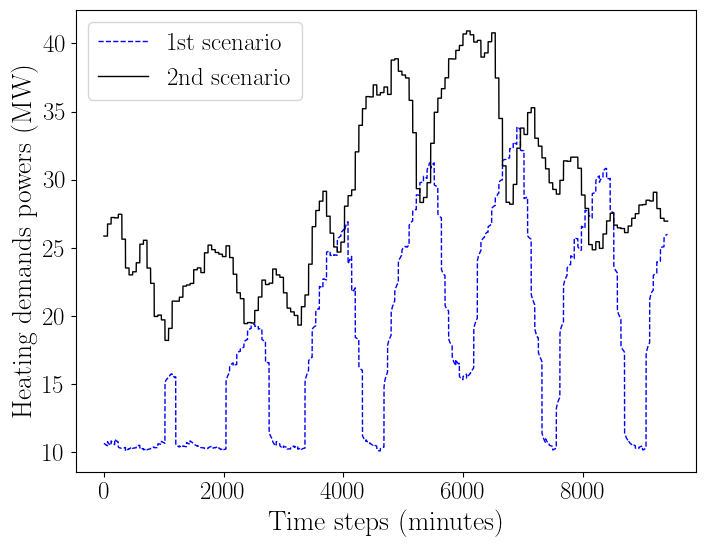

In [98]:
# Demand values from both scenarios

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(results_dicts_scenario_1['baseline']['load'].sum(axis=1) * 1e-6, '--', c='blue', label='1st scenario') # Supply temperatures at the source node v_1
ax.plot(results_dicts_scenario_2['baseline']['topology_load'].sum(axis=1) * 1e-6, c='black', label='2nd scenario') # Supply temperatures at the source node v_1
ax.set_xlabel('Time steps (minutes)')
ax.set_ylabel('Heating demands powers (MW)')
ax.legend()
plt.savefig(os.path.join('.', 'ARTICLE_images', 'heating_demands_scenario_1_and_2.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

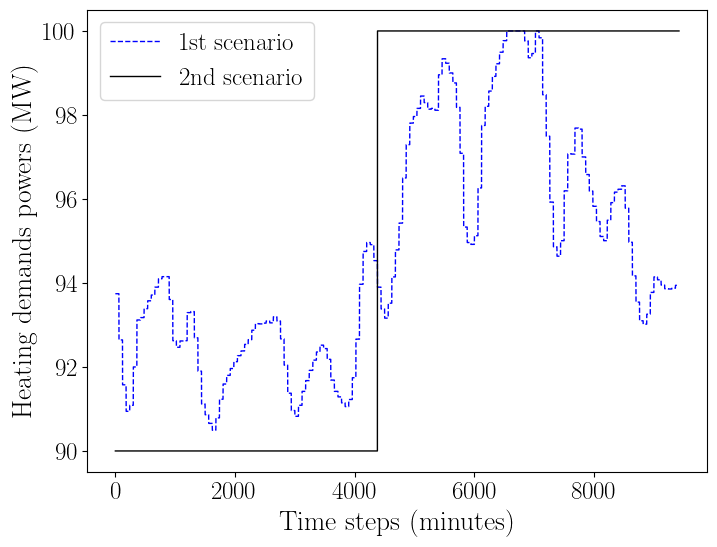

In [99]:
# Generation tss values from both scenarios

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(results_dicts_scenario_1['baseline']['ts'][:,0], '--', c='blue', label='1st scenario') # Supply temperatures at the source node v_1
ax.plot(results_dicts_scenario_2['baseline']['ts'][:,0], c='black', label='2nd scenario') # Supply temperatures at the source node v_1
ax.set_xlabel('Time steps (minutes)')
ax.set_ylabel('Heating demands powers (MW)')
ax.legend()
plt.savefig(os.path.join('.', 'ARTICLE_images', 'used_tss_scenario_1_and_2.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

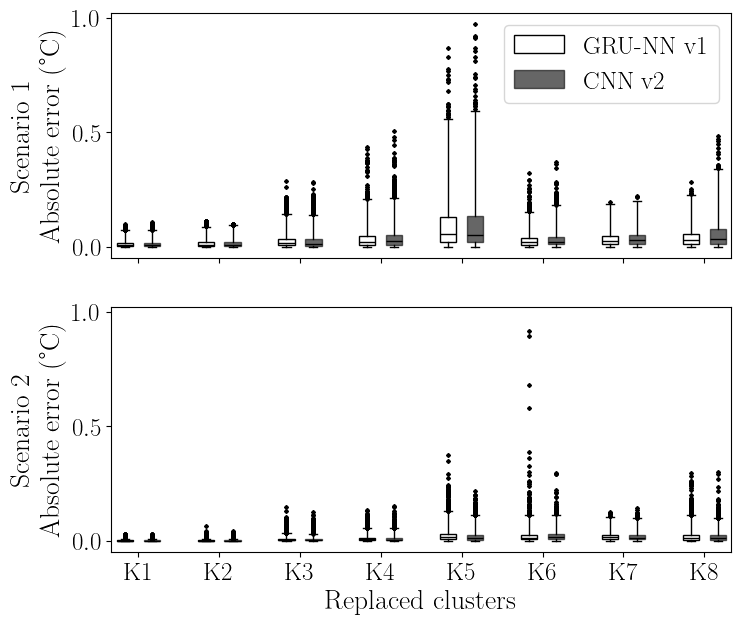

In [106]:
# Boxplot of errors on sources return temperatures

fig, axes = plt.subplots(figsize=(8,7), nrows=2, sharex=True, sharey=True)
# fig.tight_layout(pad=0.1)
clusters_names = []
indx = 0
for i, key in enumerate(results_dicts_scenario_1['rnn'].keys()):
    boxes = axes[0].boxplot(results_dicts_scenario_1['rnn'][key]['Source gen (errors)'].reshape(-1,1),
                          positions=[indx],   
                        patch_artist=True,
                        widths=0.6,
                        showfliers=True,
                        whis=4.0,
                        flierprops=dict(marker='D', markerfacecolor='black', markersize=2),
                        boxprops={'color':'black', 'facecolor':'white'}, 
                        whiskerprops={'color': 'black'},
                        capprops={'color': 'black'},
                        medianprops={'color': 'black'},)
    
    boxes_ = axes[0].boxplot(results_dicts_scenario_1['cnn'][key]['Source gen (errors)'].reshape(-1,1),
                          positions=[indx+1],   
                        patch_artist=True,
                        widths=0.6,
                        showfliers=True,
                        whis=4.0,
                        flierprops=dict(marker='D', markerfacecolor='black', markersize=2),
                        boxprops={'color':'black', 'facecolor':'black', 'alpha':0.6}, 
                        whiskerprops={'color': 'black'},
                        capprops={'color': 'black'},
                        medianprops={'color': 'black'},)
    indx+=3
    clusters_names.append(f'K{i+1}')
  
axes[0].legend([boxes["boxes"][0], boxes_["boxes"][0]], ['GRU-NN v1', 'CNN v2'], loc='upper right', prop={'size': 18})

indx = 0
# axes[0].set_xticklabels(clusters_names)
for i, key in enumerate(results_dicts_scenario_2['rnn'].keys()):
    boxes = axes[1].boxplot(results_dicts_scenario_2['rnn'][key]['Source gen (errors)'].reshape(-1,1),
                          positions=[indx],   
                        patch_artist=True,
                        widths=0.6,
                        showfliers=True,
                        whis=4.0,
                        flierprops=dict(marker='D', markerfacecolor='black', markersize=2),
                        boxprops={'color':'black', 'facecolor':'white'}, 
                        whiskerprops={'color': 'black'},
                        capprops={'color': 'black'},
                        medianprops={'color': 'black'},)
    
    boxes_ = axes[1].boxplot(results_dicts_scenario_2['cnn'][key]['Source gen (errors)'].reshape(-1,1),
                          positions=[indx+1],   
                        patch_artist=True,
                        widths=0.6,
                        showfliers=True,
                        whis=4.0,
                        flierprops=dict(marker='D', markerfacecolor='black', markersize=2),
                        boxprops={'color':'black', 'facecolor':'black', 'alpha':0.6}, 
                        whiskerprops={'color': 'black'},
                        capprops={'color': 'black'},
                        medianprops={'color': 'black'},)
    indx+=3
    # clusters_names.append(f'K{i+1}')
    
list_ticks = np.array(axes[0].get_xticks())
# print(list_ticks)
axes[1].set_xticks(np.arange(0.5,list_ticks[-1],3))
axes[1].set_xticklabels(clusters_names)

axes[0].set_ylabel('Scenario 1 \nAbsolute error (°C)')
axes[1].set_ylabel('Scenario 2 \nAbsolute error (°C)')
axes[1].set_xlabel('Replaced clusters')

# axes[1].legend([boxes["boxes"][0], boxes_["boxes"][0]], ['GRU-NN v1', 'CNN v2'], loc='upper right', prop={'size': 18})


# fig.supylabel('common_y')
fig.savefig(os.path.join('ARTICLE_images', 'boxplots_errors_tr_sources_rnn_cnn.pdf'), format='pdf', dpi='figure')

plt.show()

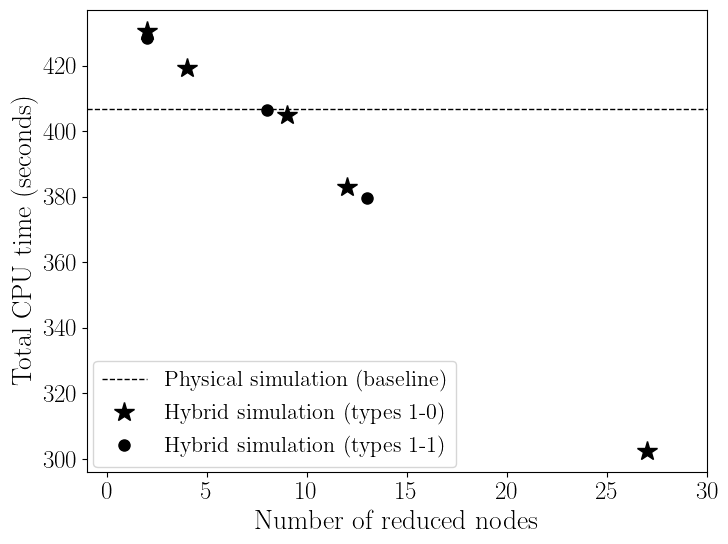

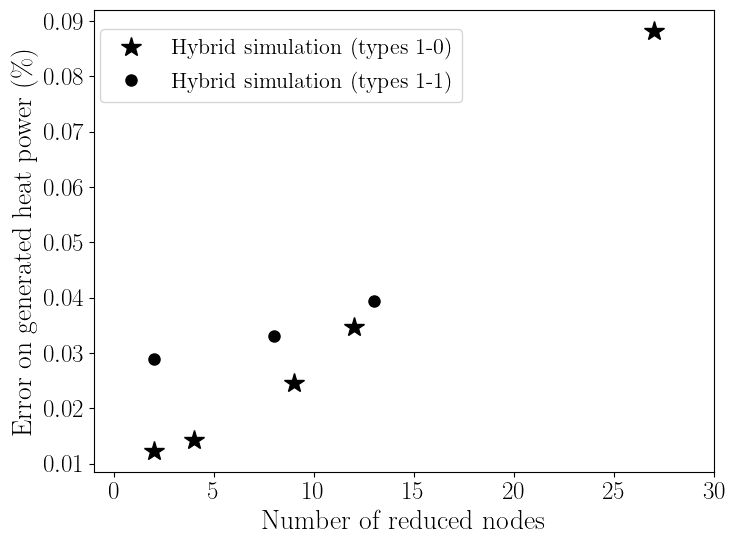

In [69]:
# CPU time plots and performs for Abstract Graphic

model_key = 'rnn'
considered_clusters_keys = results_dicts_scenario_1[model_key].keys()

nb_nodes = []
perc_nodes = []
mean_error_gen_power = []
mean_error_gen_power_conf = []
mean_error_thermal_loads = []
mean_error_thermal_loads_conf = []
types = []

ml_mean_inference_time = 0.01 # 10 ms from 100 measures (predictions) averaged

# Measure from Julia, averaged with 5 measures
resolution_times_from_julia = {
   'a': 1.963,
   'b': 1.895,
   'd': 1.81,
   'e': 1.68,
   'g': 1.951,
   'i': 1.82,
   'm': 1.66,
   'f': 1.20,
}

cpu_times = []

for indx, key in enumerate(considered_clusters_keys):
    dict_ = results_dicts_scenario_1[model_key][key]
        
    nb_nodes.append(dict_['clustered_nodes_number'])
    perc_nodes.append(dict_['clustered_nodes_percentage'])
    mean_error_gen_power.append(dict_['Source gen (MARE)'])
    mean_error_gen_power_conf.append(dict_['Source gen (MARE-Conf_interval)'])
    mean_error_thermal_loads.append(dict_['Thermal loads (MARE)'])
    mean_error_thermal_loads_conf.append(dict_['Thermal loads (MARE-Conf_interval)'])
    types.append(dict_['type'])
    cpu_time = (resolution_times_from_julia[key] + (ml_mean_inference_time*60))*7*24
    cpu_times.append(cpu_time)

colors = []
markers = []
types_1_0 = []
types_1_1 = []

error_to_use = mean_error_gen_power
error_bar_to_use = mean_error_gen_power_conf
types_1_0_error_bar = []
types_1_1_error_bar = []
for i, typ in enumerate(types):
    if typ == '1-0':
        types_1_0.append([nb_nodes[i], error_to_use[i], cpu_times[i]])
        types_1_0_error_bar.append([nb_nodes[i], error_bar_to_use[i]])
    else:
        types_1_1.append([nb_nodes[i], error_to_use[i], cpu_times[i]])
        types_1_1_error_bar.append([nb_nodes[i], error_bar_to_use[i]])

types_1_0 = np.array(types_1_0)
types_1_1 = np.array(types_1_1)

fig, ax = plt.subplots(figsize=(8,6))
resolution_time_original = np.mean([2.38, 2.2, 2.685]) * 7*24
# ax.plot(resolution_time_original * np.ones(np.max(types_1_0[:,0])))
ax.axhline(resolution_time_original, linestyle='--', c='black', label='Physical simulation (baseline)')
ax.plot(types_1_0[:,0], types_1_0[:,2], '*', markersize=15, c='black', label='Hybrid simulation (types 1-0)')
ax.plot(types_1_1[:,0], types_1_1[:,2], 'o', markersize=8, c='black', label='Hybrid simulation (types 1-1)')
ax.legend(loc=(0.01,0.01), fontsize=16)
ax.set_xlabel('Number of reduced nodes')
ax.set_ylabel('Total CPU time (seconds)')
ax.set_xlim([-1,30])

# sizes = []
# for i in types_1_0[:,0]:
#     if i not in sizes:
#         sizes.append(i)
# for i in types_1_1[:,0]:
#     if i not in sizes:
#         sizes.append(i)

# ax.set_xticks(range(len(sizes)+1), )
# x_axis = [0, *sizes]
# ax.set_xticklabels(x_axis)
# ax.legend(prop={'size': 16})

# ax.set_xticks(range(0,8))
# ax.set_xticklabels([0, *sizes])
# ax.legend(prop={'size': 16})

fig.savefig(os.path.join('ARTICLE_images', 'cpu_times_vs_number_nodes_clustered_rnn.pdf'), format='pdf', dpi='figure')
fig.savefig(os.path.join('ARTICLE_images', 'cpu_times_vs_number_nodes_clustered_rnn.svg'), format='svg', dpi='figure')
fig.savefig(os.path.join('ARTICLE_images', 'cpu_times_vs_number_nodes_clustered_rnn.png'), format='png', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(types_1_0[:,0], types_1_0[:,1], '*', markersize=15, c='black', label='Hybrid simulation (types 1-0)')
ax.plot(types_1_1[:,0], types_1_1[:,1], 'o', markersize=8, c='black', label='Hybrid simulation (types 1-1)')
ax.legend(loc=(0.01,0.8), fontsize=16)
ax.set_xlabel('Number of reduced nodes')
ax.set_ylabel('Error on generated heat power (\%)')
ax.set_xlim([-1,30])


fig.savefig(os.path.join('ARTICLE_images', 'pw_gen_error_vs_number_nodes_clustered_rnn.pdf'), format='pdf', dpi='figure')
fig.savefig(os.path.join('ARTICLE_images', 'pw_gen_error_vs_number_nodes_clustered_rnn.svg'), format='svg', dpi='figure')
fig.savefig(os.path.join('ARTICLE_images', 'pw_gen_error_vs_number_nodes_clustered_rnn.png'), format='png', dpi=1200)
plt.show()

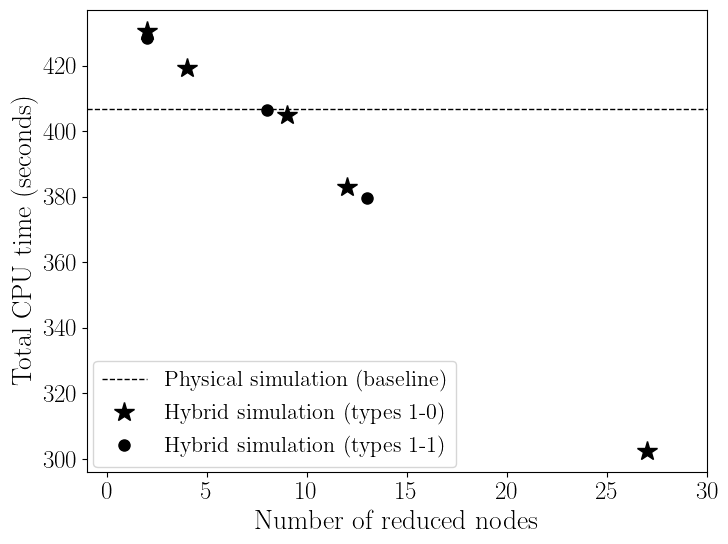

In [70]:
# CPU time plots and performs for Abstract Graphic

model_key = 'cnn'
considered_clusters_keys = results_dicts_scenario_1[model_key].keys()

nb_nodes = []
perc_nodes = []
mean_error_gen_power = []
mean_error_gen_power_conf = []
mean_error_thermal_loads = []
mean_error_thermal_loads_conf = []
types = []

ml_mean_inference_time = 0.01 # 10 ms from 100 measures (predictions) averaged

# Measure from Julia, averaged with 5 measures
resolution_times_from_julia = {
   'a': 1.963,
   'b': 1.895,
   'd': 1.81,
   'e': 1.68,
   'g': 1.951,
   'i': 1.82,
   'm': 1.66,
   'f': 1.20,
}

cpu_times = []

for indx, key in enumerate(considered_clusters_keys):
    dict_ = results_dicts_scenario_1[model_key][key]
        
    nb_nodes.append(dict_['clustered_nodes_number'])
    perc_nodes.append(dict_['clustered_nodes_percentage'])
    mean_error_gen_power.append(dict_['Source gen (MARE)'])
    mean_error_gen_power_conf.append(dict_['Source gen (MARE-Conf_interval)'])
    mean_error_thermal_loads.append(dict_['Thermal loads (MARE)'])
    mean_error_thermal_loads_conf.append(dict_['Thermal loads (MARE-Conf_interval)'])
    types.append(dict_['type'])
    cpu_time = (resolution_times_from_julia[key] + (ml_mean_inference_time*60))*7*24
    cpu_times.append(cpu_time)

colors = []
markers = []
types_1_0 = []
types_1_1 = []

error_to_use = mean_error_gen_power
error_bar_to_use = mean_error_gen_power_conf
types_1_0_error_bar = []
types_1_1_error_bar = []
for i, typ in enumerate(types):
    if typ == '1-0':
        types_1_0.append([nb_nodes[i], error_to_use[i], cpu_times[i]])
        types_1_0_error_bar.append([nb_nodes[i], error_bar_to_use[i]])
    else:
        types_1_1.append([nb_nodes[i], error_to_use[i], cpu_times[i]])
        types_1_1_error_bar.append([nb_nodes[i], error_bar_to_use[i]])

types_1_0 = np.array(types_1_0)
types_1_1 = np.array(types_1_1)

fig, ax = plt.subplots(figsize=(8,6))
resolution_time_original = np.mean([2.38, 2.2, 2.685]) * 7*24
# ax.plot(resolution_time_original * np.ones(np.max(types_1_0[:,0])))
ax.axhline(resolution_time_original, linestyle='--', c='black', label='Physical simulation (baseline)')
ax.plot(types_1_0[:,0], types_1_0[:,2], '*', markersize=15, c='black', label='Hybrid simulation (types 1-0)')
ax.plot(types_1_1[:,0], types_1_1[:,2], 'o', markersize=8, c='black', label='Hybrid simulation (types 1-1)')
ax.legend(loc=(0.01,0.01), fontsize=16)
ax.set_xlabel('Number of reduced nodes')
ax.set_ylabel('Total CPU time (seconds)')
ax.set_xlim([-1,30])

fig.savefig(os.path.join('ARTICLE_images', 'cpu_times_vs_number_nodes_clustered_cnn.pdf'), format='pdf', dpi='figure')
fig.savefig(os.path.join('ARTICLE_images', 'cpu_times_vs_number_nodes_clustered_cnn.png'), format='png', dpi=1200)
fig.savefig(os.path.join('ARTICLE_images', 'cpu_times_vs_number_nodes_clustered_cnn.png'), format='png', dpi=1200)
plt.show()

#### *Other codes*

In [82]:
# Compute correlation factos

# gru_1_gen = [0.011, 0.012, 0.025, 0.042, 0.088]

# gru_2_gen = [0.003, 0.004, 0.008, 0.017, 0.026]

# cnn_1_gen = [0.013, 0.015, 0.024, 0.037, 0.093]
# cnn_2_gen = [0.003, 0.004, 0.008, 0.012, 0.027]

# sizes = [2,4,9,12,27]

# print(np.corrcoef(sizes, gru_1_gen))
# print(np.corrcoef(sizes, gru_2_gen))

# print(np.corrcoef(sizes, cnn_1_gen))
# print(np.corrcoef(sizes, cnn_2_gen))

In [ ]:
# fig, ax = plt.subplots(figsize=(6,4))
# xaxis = [0, *number_nodes]
# yaxis = [resolution_time_original, *cpu_times]
# ax.scatter([0], [resolution_time_original], marker='v', color='black', s=250, label='Original network', alpha=1.0)
# ax.scatter(range(1, len(cpu_times)+1), cpu_times, alpha=1.0, s=350, marker='*', label='Reduced networks', c='black')
# ax.axhline(y=resolution_time_original, color='black', linestyle='--')
# ax.set_xticks(range(len(cpu_times)+1), )
# x_axis = [0, *number_nodes]
# ax.set_xticklabels(x_axis)
# ax.legend(prop={'size': 16})
# # ax.spines['bottom'].set_color('black')
# ax.spines['top'].set_color('black') 
# ax.spines['right'].set_color('black')
# # ax.spines['right'].set_linewidth(3)
# ax.spines['left'].set_color('black')
# # ax.spines['left'].set_lw(3)
# ax.xaxis.label.set_color('black')
# ax.yaxis.label.set_color('black')
# ax.tick_params(colors='black', which='both')
# # ax.set_xlabel('Number of nodes aggregated')
# # ax.set_ylabel('CPU time per step (seconds)')
# # ax.xaxis.tick_top()
# # ax.xaxis.set_label_position('top') 

# # axx = ax.twiny()
# # axx.scatter([0], [resolution_time_original], marker='v', color='black', s=150, label='full network physic-based simulation', alpha=0.8)
# # axx.scatter(range(1, len(cpu_times)+1), cpu_times, alpha=0.7, s=220, marker='*', label='reduced networks hybrid simulations', c='black')
# # axx.axhline(y=resolution_time_original, color='black', linestyle='--')
# # axx.set_xticks(range(len(cpu_times)+1))
# # x_axis = [0, *number_nodes]
# # axx.legend()
# # axx.set_xlabel('Percentage of aggregated nodes (\%)')
# # axx.set_ylabel('CPU time per step (seconds)')
# # axx.set_xticks(range(len(cpu_times)+1))
# # xx_axis = [int(100*i/71) for i in x_axis]
# # axx.set_xticklabels(xx_axis)

# fig.set_size_inches(6, 3.5)
# fig.tight_layout()

# fig.savefig(os.path.join('ARTICLE_images', 'cpu_times_vs_nodes_graph.png'), format='png', dpi=1000)
# plt.show()